## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")



In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data = brent_data.sort_index()
brent_data.shape


(2667, 11)

In [6]:
#Вычисляем первые разности стоимости нефти
brent_data['diff_1'] = (brent_data['Значение'] - brent_data['Значение'].shift(1)).fillna(0)
d_brent_data = brent_data['Значение'].values[1:] - brent_data['Значение'].values[:-1]

#### 2. Добавьте первые разности по стоимости доллара и евро к рублю

Естественным попутчиком любого финансово -ориентированного ряда является кросс-курс валют. В случае BRENT патриотично рассматриваем кросс-курс доллар-рубль (стоимость доллара в рублях) и евро-рубль (стоимость евро в рублях). Интервал измерения стоимости доллара и евро соответствует частоте и периоду нашего ряда "стоимость нефти", а источник данных https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=01.09.2010&UniDbQuery.ToDate=01.09.2019, который позволяет сохранить результаты в нескольких различных вариантах. Прочитаем, сохраненные данные.

In [7]:
# Считываем курсы валют из внешних источников
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()



,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [8]:
rub_e=pd.read_excel('RC_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()



,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


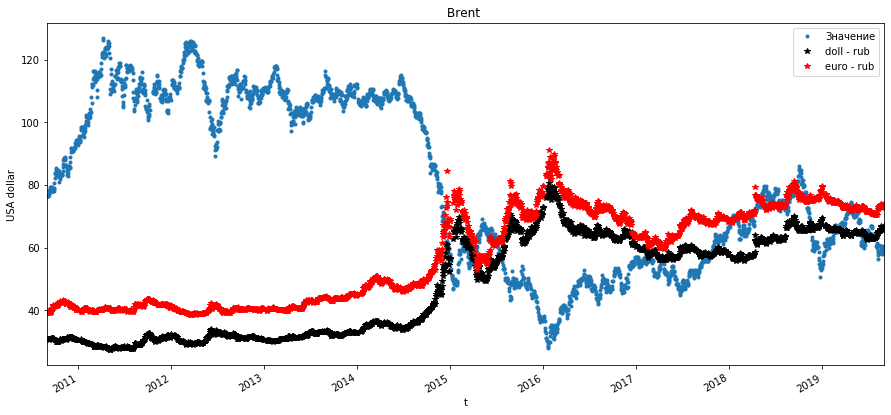

In [9]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Посмотрим на первые разности. Помним, что для BRENT первые разности стационарны. Проверим как выглядят они для кросс-курсов.

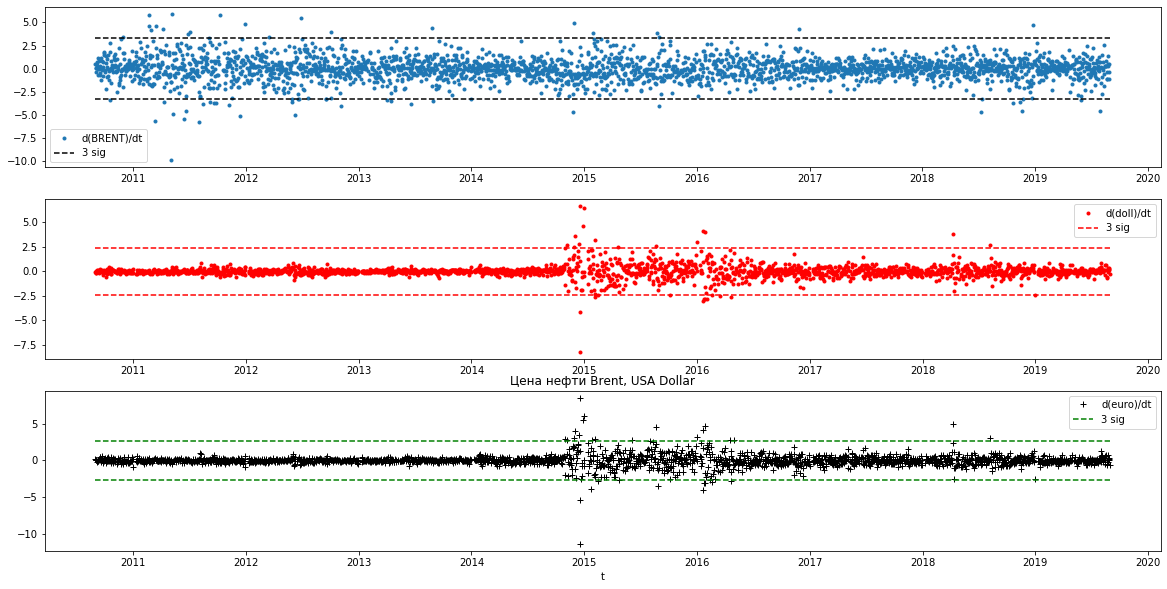

In [11]:
s_brent = np.std(d_brent_data)**0.5*3
d_rub_doll = rub_doll['curs'].values[1:] - rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:] - rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]




In [10]:
brent_data['rub_doll'] = rub_doll
brent_data['rub_doll'] = brent_data['rub_doll'].interpolate(method ='linear', limit_direction ='forward')
brent_data['rub_e'] = rub_e
brent_data['rub_e'] = brent_data['rub_e'].interpolate(method ='linear', limit_direction ='forward')


In [15]:
brent_data['d_rub_doll'] = (brent_data['rub_doll'] - brent_data['rub_doll'].shift(1)).fillna(0)
brent_data['d_rub_e'] = (brent_data['rub_e'] - brent_data['rub_e'].shift(1)).fillna(0)




### 3. Сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [12]:
brent_data_w = brent_data.resample('W').mean()
#Удаляем столбцы, которые стали неинформативными 
brent_data_w.drop(columns = ['year', 'dayofmonth', 'dayofyear', 
                            'is_holiday', 'is_prev_holiday', 'is_next_holiday', 'dayofweek'], inplace=True)

In [13]:
brent_data_w.head()

,Значение,month,quarter,weekofyear,diff_1,rub_doll,rub_e
Дата,,,,,,,
2010-09-05,76.616000,9.000000,3.000000,35.0,0.052000,30.739767,39.241940
2010-09-12,77.673333,9.000000,3.000000,36.0,0.288333,30.764261,39.316383
2010-09-19,78.693333,9.000000,3.000000,37.0,-0.021667,30.824650,39.787733
2010-09-26,78.518333,9.000000,3.000000,38.0,0.118333,30.985900,40.975428
2010-10-03,81.211667,9.333333,3.333333,39.0,0.791667,30.563028,41.340456


In [14]:
brent_data_w['date'] = brent_data_w.index

In [15]:
brent_data_w.loc[brent_data_w['Значение'].isnull()]



,Значение,month,quarter,weekofyear,diff_1,rub_doll,rub_e,date
Дата,,,,,,,,
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-10-16


In [16]:
brent_data_w['year'] = brent_data_w['date'].dt.year
brent_data_w['month'] = brent_data_w['date'].dt.month
brent_data_w['quarter'] = brent_data_w['date'].dt.quarter
brent_data_w['weekofyear'] = brent_data_w['date'].dt.weekofyear
brent_data_w.drop(columns = ['date'], inplace=True)
brent_data_w.head()

,Значение,month,quarter,weekofyear,diff_1,rub_doll,rub_e,year
Дата,,,,,,,,
2010-09-05,76.616000,9,3,35,0.052000,30.739767,39.241940,2010
2010-09-12,77.673333,9,3,36,0.288333,30.764261,39.316383,2010
2010-09-19,78.693333,9,3,37,-0.021667,30.824650,39.787733,2010
2010-09-26,78.518333,9,3,38,0.118333,30.985900,40.975428,2010
2010-10-03,81.211667,10,4,39,0.791667,30.563028,41.340456,2010


### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [17]:
p = 4

#добавляем историю длиной р
for i in range(p):
    brent_data_w['t'+str(p-i)]=0.
    brent_data_w['t'+str(p-i)].values[p+1:] = brent_data_w['Значение'].values[i+1:-(p-i)]
for i in range(p):
    brent_data_w['d'+str(p-i)]=0.   
    brent_data_w['d'+str(p-i)].values[p+1:] = brent_data_w['diff_1'].values[i+1:-(p-i)]

brent_data_w.drop(brent_data_w.index[:4], inplace=True)

In [18]:
brent_data_w = brent_data_w.interpolate(method ='linear', limit_direction ='forward')

Выделение существенных признаков

Составим финальную систему признаков и проведем ее анализ. 

Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)


In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [20]:
scl_target=StandardScaler() 

h=1
target = brent_data_w["Значение"].values[h:].reshape((brent_data_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(465, 1)

In [21]:
scl_x=StandardScaler() 

X = brent_data_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(465, 16)

In [22]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=65200.22,  I=0
F-test=0.10,  I=1
F-test=0.16,  I=2
F-test=0.23,  I=3
F-test=2.30,  I=4
F-test=2868.82,  I=5
F-test=1866.56,  I=6
F-test=521.03,  I=7
F-test=5629.94,  I=8
F-test=6839.30,  I=9
F-test=8582.29,  I=10
F-test=11338.58,  I=11
F-test=2.72,  I=12
F-test=2.53,  I=13
F-test=2.64,  I=14
F-test=2.54,  I=15


Применим автоматизацию выбора через SelectKBest c выделением 8 лучших признаков.

In [32]:
sfk1 =SelectKBest(f_regression, k=8)
X_new1 =sfk1.fit_transform(X, y.ravel())
X_new1.shape

(465, 8)

In [33]:
column_names = brent_data_w.columns[sfk1.get_support()]
column_names

Index(['Значение', 'rub_doll', 'rub_e', 'year', 't4', 't3', 't2', 't1'], dtype='object')

In [34]:
sfk2=SelectKBest(mutual_info_regression, k=8)
X_new2 = sfk2.fit_transform(X, y.ravel())
X_new2.shape

(465, 8)

In [37]:
column_names = brent_data_w.columns[sfk2.get_support()]
column_names

Index(['Значение', 'rub_doll', 'rub_e', 'year', 't3', 't2', 't1'], dtype='object')

In [39]:
gr_model = GradientBoostingRegressor(max_depth=6, random_state=42, n_estimators=300).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape



(465, 3)

In [40]:
column_names = brent_data_w.columns[sfm.get_support()]
column_names

Index(['Значение', 'rub_doll', 'rub_e'], dtype='object')

In [41]:
list_param_k1 =np.where(sfk1.get_support())[0]
list_param_k2 =np.where(sfk2.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k1 лучших : ',list_param_k1)
print('Номера признаков k2 лучших: ',list_param_k2)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k1 лучших :  [ 0  5  6  7  8  9 10 11]
Номера признаков k2 лучших:  [ 0  5  6  7  8  9 10 11]
Номера признаков для выбора по модели :  [0 5 6]


In [43]:
par_with_val = [0,5,6, 7, 8, 9, 10,11]
par_without_val = [0, 7, 8, 9, 10,11]
X_with_val = X[:,par_with_val]
X_without_val = X[:,par_without_val]

In [44]:
# Список параметров с курсами валют
brent_data_w.columns[par_with_val]

Index(['Значение', 'rub_doll', 'rub_e', 'year', 't4', 't3', 't2', 't1'], dtype='object')

In [45]:
# Список параметров без курсов валют
brent_data_w.columns[par_without_val]

Index(['Значение', 'year', 't4', 't3', 't2', 't1'], dtype='object')

#### Разделение данных на тестовые и тренировочные

In [46]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

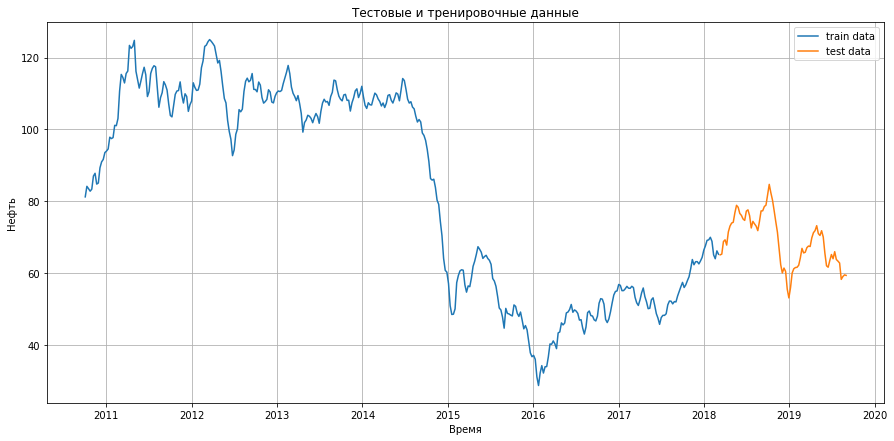

In [61]:
train, test = split_data(brent_data_w, -78)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [62]:
X_train_val = X_with_val[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test_val = X_with_val[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [63]:
X_train = X_without_val[:train.shape[0],:]
X_test = X_without_val[train.shape[0]:,:]

#### Модель валютных признаков

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
model_g = GradientBoostingRegressor(max_depth=6, random_state=42, n_estimators=300)

In [66]:
model_g.fit( X_train, y_train )
y_pred_g = model_g.predict(X_train)
y_test_pred_g = model_g.predict(X_test)

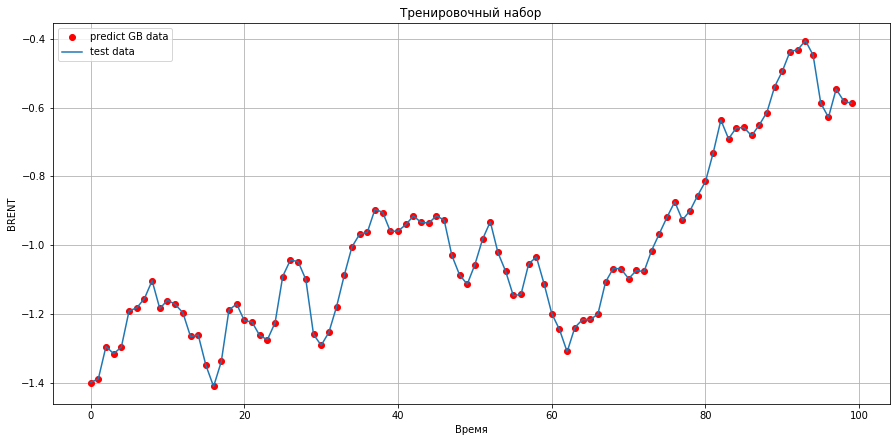

In [67]:
plt.figure( figsize=( 15, 7 ))

plt.title('Тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()



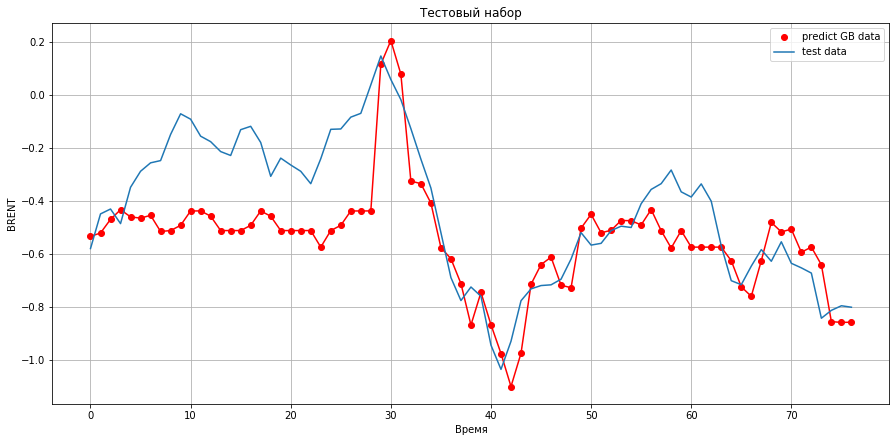

In [68]:
plt.figure( figsize=( 15, 7 ))
plt.title('Тестовый набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g,'or', label='predict GB data' )
plt.plot(y_test_pred_g,'r' )
plt.plot(y_test, label='test data')
plt.grid()
plt.legend()
plt.show()

In [70]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.039203355445671474 
ошибка mae  :   0.1566802588013592 
оценка R2 :   0.44803432414973976


In [71]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [72]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.821204374574909 %


#### Модель с валютными признаками

In [73]:
model_g.fit( X_train_val, y_train )
y_pred_g = model_g.predict(X_train_val)
y_test_pred_g = model_g.predict(X_test_val)

In [74]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.033378051634285054 
ошибка mae  :   0.14128668731035784 
оценка R2 :   0.5300519912277759


In [75]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')



ошибка градиентного бустинга MAPE :   5.2055497675773035 %


### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

ошибка MAPE при использовании валютных признаков, уменьшилась на 0,6%

Однако, когда я выбирал тестовый набор данных не полтора года, а два, ошибка наоборот была больше на 2%. Но предполагаю по первым графикам, что валютные признаки обычно улучшают прогноз. 
